In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'

## JWST

In [3]:
df_jwst = pd.read_csv('jwst.tsv', sep='\t')
df_jwst.head(5)

,year,plan,remaining
0,1997,2007.0,10
1,1998,2007.0,9
2,1999,2007.5,8-9
3,2000,2009.0,9
4,2002,2010.0,8


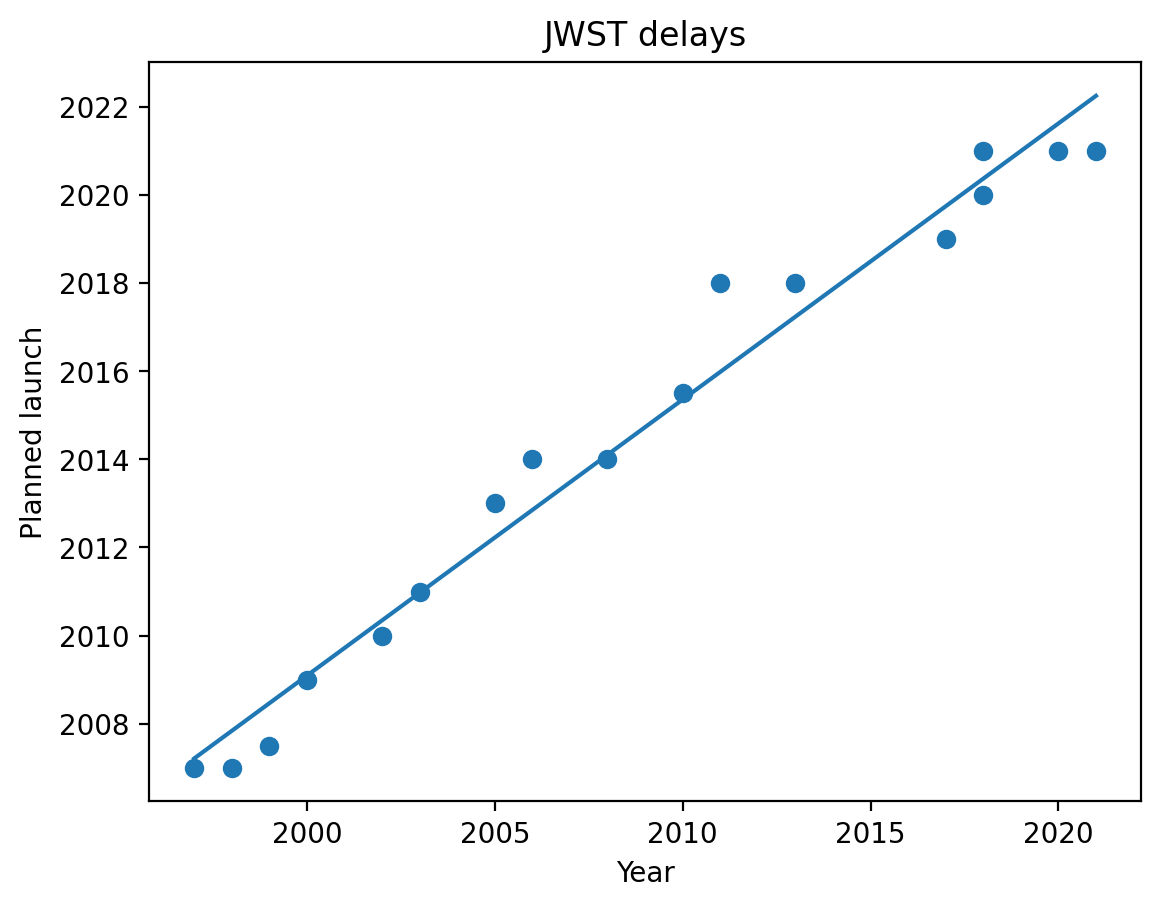

In [4]:
plt.scatter(df_jwst['year'], df_jwst['plan'])
plt.xlabel('Year')
plt.ylabel('Planned launch')
plt.title('JWST delays')

coefficients = np.polyfit(df_jwst['year'], df_jwst['plan'], 1)
line = np.poly1d(coefficients)

plt.plot(df_jwst['year'], line(df_jwst['year']))

plt.show()

In [5]:
print('Coefficient of plan/year:', coefficients[0])

Coefficient of plan/year: 0.6263793864489021


## Artemis Delays

In [6]:
df_artemis = pd.read_csv('artemis.tsv', sep='\t')
for col in df_artemis.columns[1:]:
    df_artemis[col] = pd.to_datetime(df_artemis[col])
df_artemis

,Year,Artemis1,Artemis2,Artemis3,Artemis4,Artemis5,Artemis6
0,2020,2021-01-01,2022-11-01,2024-01-01,2025-01-01,2026-01-01,2027-01-01
1,2021,2021-11-01,2023-08-01,2024-10-01,2026-03-01,2026-01-01,2027-01-01
2,2022,2022-08-01,2024-05-01,2025-01-01,2026-03-01,2027-01-01,2028-01-01
3,2023,NaT,2024-11-01,2025-12-01,2028-09-01,2029-09-01,2030-09-01
4,2024,NaT,2025-09-01,2026-09-01,2028-09-01,2029-09-01,2030-09-01


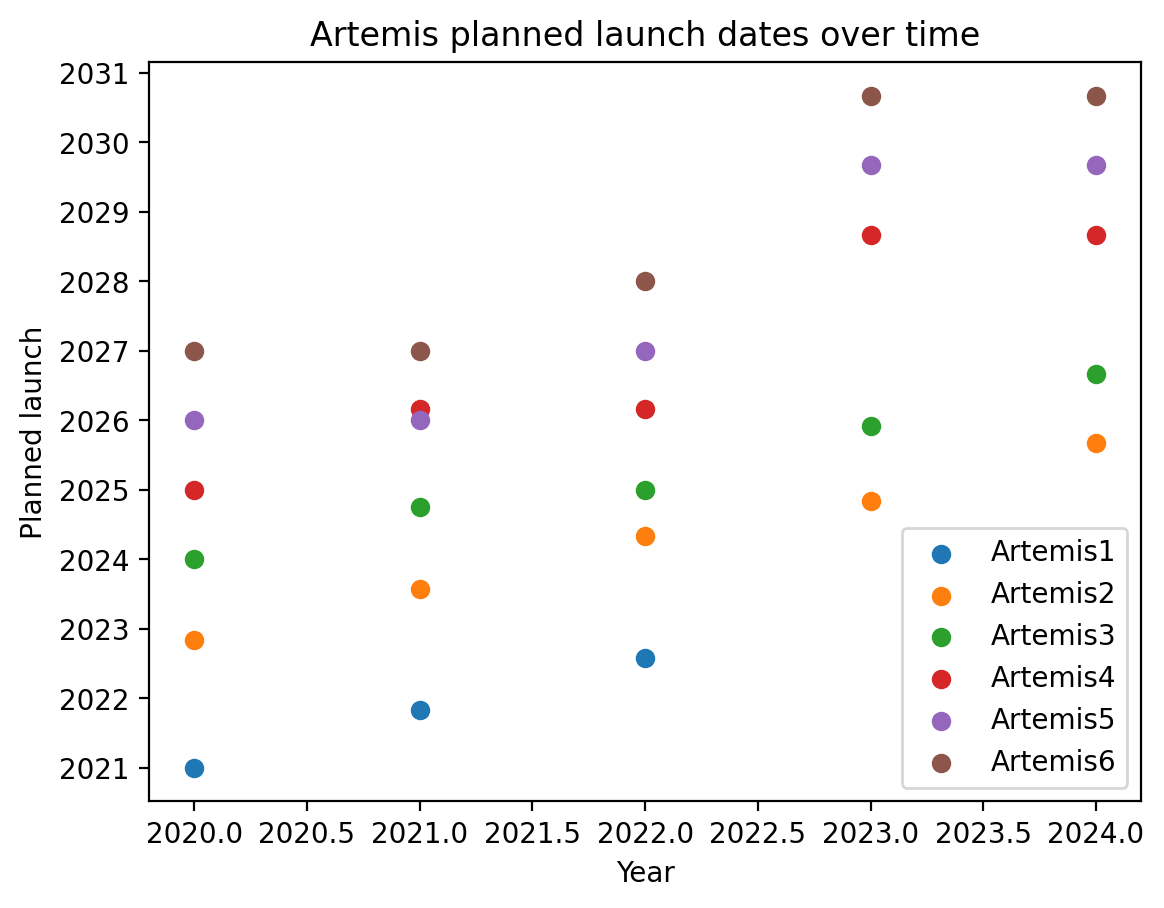

In [7]:
for col in df_artemis.columns[1:]:
    plt.scatter(df_artemis['Year'], df_artemis[col], label=col)
plt.xlabel('Year')
plt.ylabel('Planned launch')
plt.legend(loc='lower right')
plt.title('Artemis planned launch dates over time')
plt.show()

In [8]:
df_delays = df_artemis.copy()
for col in df_artemis.columns[1:]:
    df_delays[col] = (df_artemis[col] - df_artemis[col][0]).dt.days / 365
    for idx in df_artemis.index:
        dt = df_artemis['Year'][idx] - df_artemis['Year'][0]
        if df_delays.at[idx, col]:
            df_delays.at[idx, col] /= dt
        if df_delays.at[idx, col] == 0:
            df_delays.at[idx, col] = None

print('Rate paremeter for plan delays:')
df_delays

Rate paremeter for plan delays:


,Year,Artemis1,Artemis2,Artemis3,Artemis4,Artemis5,Artemis6
0,2020,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,0.832877,0.747945,0.750685,1.161644,NaN,NaN
2,2022,0.790411,0.749315,0.501370,0.580822,0.500000,0.500000
3,2023,NaN,0.667580,0.639269,1.222831,1.222831,1.222831
4,2024,NaN,0.708904,0.667123,0.917123,0.917123,0.917123


In [9]:
for rate in np.arange(0.4, 0.9, 0.1):
    mul = 1/(1-rate)
    print(f'With rate r = {rate:.1f} ({mul:.1f}x longer than expected)')
    for mission in df_delays.columns[2:]:
        now = pd.to_datetime('2024-05-01')
        plan = df_artemis[mission].values[-1]
        planned_days_to_launch = (plan - now).days
        projected_days = planned_days_to_launch / (1-rate)
        projected_date = now + pd.DateOffset(days=projected_days)
        print(f'- {mission}:', projected_date.date())
    print()

With rate r = 0.4 (1.7x longer than expected)
- Artemis2: 2026-07-23
- Artemis3: 2028-03-22
- Artemis4: 2031-07-24
- Artemis5: 2033-03-23
- Artemis6: 2034-11-21

With rate r = 0.5 (2.0x longer than expected)
- Artemis2: 2027-01-02
- Artemis3: 2029-01-01
- Artemis4: 2033-01-02
- Artemis5: 2035-01-02
- Artemis6: 2037-01-01

With rate r = 0.6 (2.5x longer than expected)
- Artemis2: 2027-09-03
- Artemis3: 2030-03-03
- Artemis4: 2035-03-05
- Artemis5: 2037-09-02
- Artemis6: 2040-03-03

With rate r = 0.7 (3.3x longer than expected)
- Artemis2: 2028-10-13
- Artemis3: 2032-02-12
- Artemis4: 2038-10-15
- Artemis5: 2042-02-12
- Artemis6: 2045-06-13

With rate r = 0.8 (5.0x longer than expected)
- Artemis2: 2031-01-05
- Artemis3: 2036-01-04
- Artemis4: 2046-01-06
- Artemis5: 2051-01-05
- Artemis6: 2056-01-04



## Final Model

In [125]:
class ParameterRegistry:
    """
    Manages the parameters of the model.
    """
    def __init__(self) -> None:
        self.params = {}
        self.simulation_counter = 0
    
    def start_simulation(self):
        self.simulation_counter += 1

    def register(self, ticker, value, bounds, desc):
        if self.simulation_counter > 1:
            return
        
        gen = value if callable(value) else lambda: value

        self.params[ticker] = {
            'description': desc,
            'default_value': gen,
            'value': gen,
            'bounds': bounds,
        }
    
    def get(self, ticker):
        return self.params[ticker]['value']()

    def tickers(self):
        return list(self.params.keys())

    def measure_sensitivity(self, ticker, simulator):
        inputs = []
        outputs = []

        N_SAMPLES = 1000

        spec = self.params[ticker]
        for val in np.linspace(spec['bounds'][0], spec['bounds'][1], 10):
            spec['value'] = lambda: val
            inputs.append(val)
            outputs.append(np.mean([simulator() for _ in range(N_SAMPLES)]))

        spec['value'] = spec['default_value']

        return outputs[0], outputs[-1]

In [140]:
PARAMS = ParameterRegistry()

def simulate():
    PARAMS.start_simulation()

    gen_art2_mult = lambda: np.random.choice([1, 2, 2.5, 3, 3.5, 5], p=[0.05, 0.1, 0.3, 0.3, 0.2, 0.05])
    PARAMS.register('ART2_PROJECTION_MULT', gen_art2_mult, (0.9, 5), 'Multiplier for time until actual Artemis 2 launch')

    now_year = 2024.33
    art2_plan = 2025.66
    art2_launch = now_year + (art2_plan - now_year) * PARAMS.get('ART2_PROJECTION_MULT')

    PARAMS.register('P_ART3+_LIKE_APOLLO', 0.3, (0.1, 0.8), 'Probability of Artemis 3+ all on schedule like Apollo')

    # Assuming _not_ like Apollo
    gen_art3plus_mult = lambda: np.random.choice([1.5, 2, 2.5, 3], p=[0.25, 0.25, 0.4, 0.1])
    PARAMS.register('ART3+_PROJECTION_MULT', gen_art3plus_mult, (0.9, 4), 'Multiplier for time until actual Artemis 3+ launch')


    if np.random.random() < PARAMS.get('P_ART3+_LIKE_APOLLO'):
        art3plus_mult = 1
    else:
        art3plus_mult = PARAMS.get('ART3+_PROJECTION_MULT')
    
    art2plus_offsets = [0, 1, 3, 4, 5] # Planned years after Artemis 2 launch
    artemis_launches = [art2_launch + offset * art3plus_mult for offset in art2plus_offsets]

    PARAMS.register('P_EXTRA_ARTEMIS', 0.4, (0.1, 0.8), 'Probability of extra Artemis missions, given Artemis 6 by 2035')

    gen_extra_artemis = lambda: np.random.randint(1, 5)
    PARAMS.register('NUM_EXTRA_ARTEMIS', gen_extra_artemis, (1, 5), 'Number of extra Artemis missions')

    if np.random.random() < PARAMS.get('P_EXTRA_ARTEMIS'):
        num_extra = PARAMS.get('NUM_EXTRA_ARTEMIS')
        artemis_launches.extend(list(range(6, round(6+num_extra))))

    PARAMS.register('P_ART_FAILURE', 0.1, (0.05, 0.15), 'Probability of Artemis mission failure')
    PARAMS.register('DELAY_FROM_ART_FAILURE', 2, (1, 3), 'Delay in years caused by Artemis mission failure')
    PARAMS.register('P_FAILURE_CANCELS_ART', 0.05, (0.01, 0.4), 'Probability of Artemis mission failure causing cancellation of Artemis program')

    for i in range(len(artemis_launches)):
        if np.random.random() < PARAMS.get('P_ART_FAILURE'):
            artemis_launches[i] = float('inf') # Never succeeds
            if np.random.random() < PARAMS.get('P_FAILURE_CANCELS_ART'):
                artemis_launches = artemis_launches[:i]
                break

            for j in range(i, len(artemis_launches)):
                artemis_launches[j] += PARAMS.get('DELAY_FROM_ART_FAILURE')

    PARAMS.register('P_NO_ARTEMIS', 0.10, (0.01, 0.3), 'Probability of no Artemis 3 by 2035')

    if np.random.random() < PARAMS.get('P_NO_ARTEMIS'):
        artemis_launches = []

    launches_by_2035 = sum(launch < 2035 for launch in artemis_launches)

    PARAMS.register('CHINA_BY_2030', 0.74, (0.5, 0.9), 'China lands on the moon by 2030')
    PARAMS.register('CHINA_BY_2035_IF_>2030', 0.2, (0.1, 0.7), 'China lands on the moon by 2035, if not by 2030')

    PARAMS.register('P_CHINA_EXTRA_IF_2030', 0.4, (0.1, 0.8), 'Prob China does extra landings if they land by 2030')

    gen_china_extra = lambda: np.random.choice([1, 2, 3], p=[0.4, 0.35, 0.25])
    PARAMS.register('CHINA_EXTRA_IF_2030', gen_china_extra, (0, 3), 'Extra China landings by 2035')

    china_by_2030 = np.random.random() < PARAMS.get('CHINA_BY_2030')
    if china_by_2030:
        china_launches = 1
        if np.random.random() < PARAMS.get('P_CHINA_EXTRA_IF_2030'):
            china_launches += PARAMS.get('CHINA_EXTRA_IF_2030')
    else:
        china_launches = int(np.random.random() < PARAMS.get('CHINA_BY_2035_IF_>2030'))
    
    launches_by_2035 += china_launches
    
    return launches_by_2035

_ = simulate()

Mean: 4.7871
80% CI: [2. 8.]


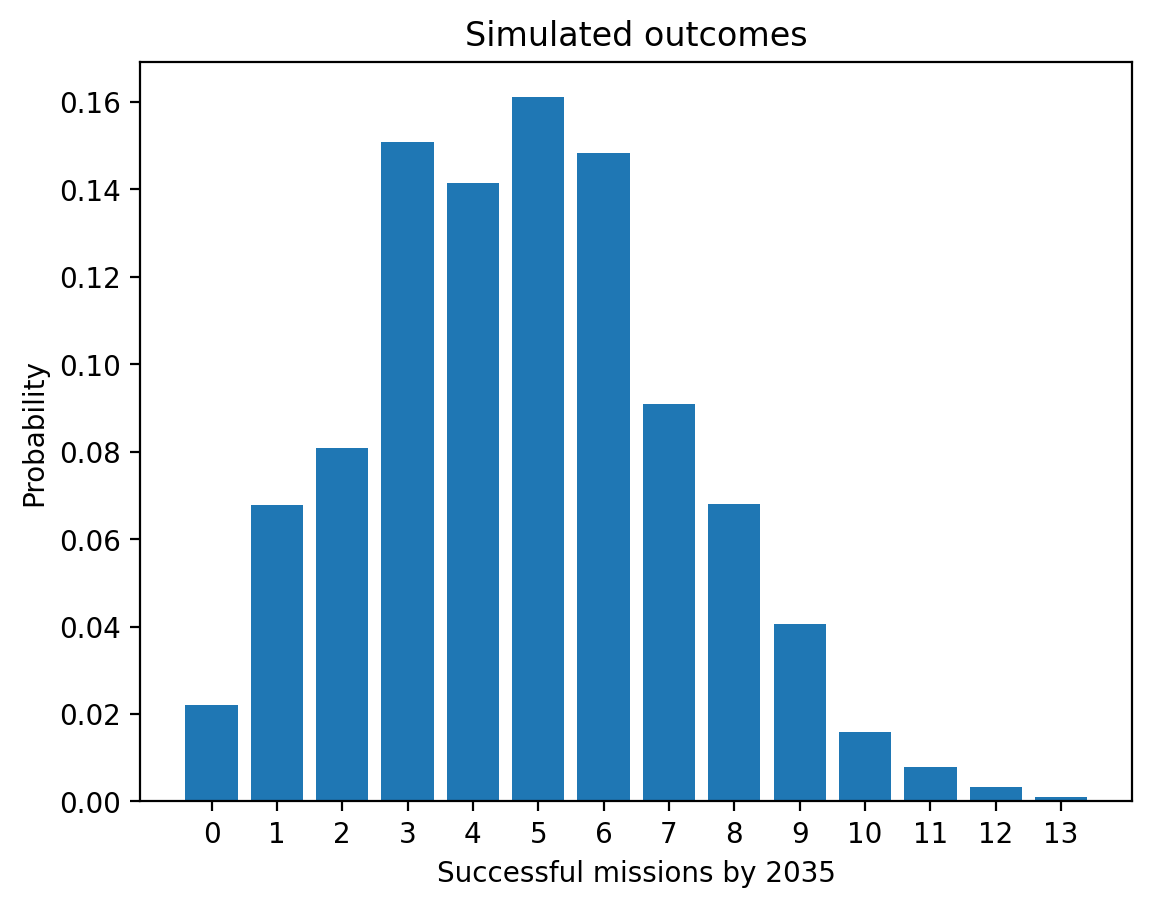

In [146]:
samples = [simulate() for _ in range(10_000)]

print('Mean:', np.mean(samples))
print('80% CI:', np.percentile(samples, [10, 90]))

key, counts = np.unique(samples, return_counts=True)
counts = np.array(counts) / len(samples)

plt.bar(key, counts)
plt.title('Simulated outcomes')
plt.xticks(range(0, max(key)+1))
plt.xlabel('Successful missions by 2035')
plt.ylabel('Probability')
plt.savefig('pdf.png')
plt.show()

In [135]:
sensitivities = []


for ticker in PARAMS.tickers():
    low, high = PARAMS.measure_sensitivity(ticker, simulate)

    spec = PARAMS.params[ticker]
    sensitivities.append({
        'parameter': ticker,
        'value': np.mean([spec['value']() for _ in range(1000)]),
        'low': spec['bounds'][0],
        'high': spec['bounds'][1],
        'min(outcome)': min(low, high),
        'max(outcome)': max(low, high),
        'diff(outcome)': abs(high - low),
    })

print('Column descriptions:')
print(' low = lowest plausible value')
print(' high = highest plausible value')
print(' min(outcome) = min mean outcome based on param')
print(' max(outcome) = max mean outcome based on param')
print(' diff(outcome) = max(outcome) - min(outcome)')

df = pd.DataFrame.from_dict(sensitivities).round(decimals=2)
df

Column descriptions:
 low = lowest plausible value
 high = highest plausible value
 min(outcome) = min mean outcome based on param
 max(outcome) = max mean outcome based on param
 diff(outcome) = max(outcome) - min(outcome)


,parameter,value,low,high,min(outcome),max(outcome),diff(outcome)
0,ART2_PROJECTION_MULT,2.88,0.90,5.00,4.04,5.24,1.20
1,P_ART3+_LIKE_APOLLO,0.30,0.10,0.80,4.53,5.46,0.94
2,ART3+_PROJECTION_MULT,2.17,0.90,4.00,4.43,6.00,1.57
3,P_EXTRA_ARTEMIS,0.40,0.10,0.80,4.18,5.57,1.39
4,NUM_EXTRA_ARTEMIS,2.52,1.00,5.00,4.43,5.53,1.10
5,P_ART_FAILURE,0.10,0.05,0.15,4.62,5.14,0.51
6,DELAY_FROM_ART_FAILURE,2.00,1.00,3.00,4.75,4.81,0.06
7,P_FAILURE_CANCELS_ART,0.05,0.01,0.40,4.54,4.89,0.36
8,P_NO_ARTEMIS,0.10,0.01,0.30,3.94,5.29,1.34
9,CHINA_BY_2030,0.74,0.50,0.90,4.45,5.10,0.66
